<a href="https://colab.research.google.com/github/mostaphafakihi/Financial-Resilience-Challenge-/blob/main/Financial_Resilience_Challenge_vf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_validate
plt.rcParams['figure.figsize'] = (12, 9)


**Importation des données**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/data/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/data/Test (1).csv')


# **Exploration et analyse de données :**

In [ ]:
train.shape

(104867, 36)

In [ ]:
train.sample(10)

,ID,country,region,population,age,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10a,Q10b,Q11,Q12,Q13a,Q14,Q15,Q16,Q17a,Q17b,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,owns_mobile,Q28,target
46418,ID_4433119324,"Venezuela, RB",Latin America & Caribbean (excluding high income),2.276236e+07,40.0,1,1.0,1.0,2.0,2.0,2,NaN,1.0,1.0,2,2,2,2,2,2,2,2,2,2,2.0,2.0,1,2,NaN,2,2,2.0,2.0,1.0,1.0,1
59594,ID_5698135975,Azerbaijan,Europe & Central Asia (excluding high income),7.500482e+06,32.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,1,2.0,1.0,3,2,NaN,2,2,2.0,2.0,2.0,1.0,1
34637,ID_3318769003,Slovenia,High income: OECD,1.758821e+06,62.0,2,NaN,NaN,2.0,2.0,2,NaN,1.0,1.0,2,1,2,2,2,2,2,2,2,2,NaN,NaN,2,2,NaN,2,2,NaN,2.0,1.0,NaN,0
8986,ID_0859146438,Belgium,High income: OECD,9.415427e+06,73.0,1,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1,1,2,2,1,1,2,2,1,2,NaN,NaN,1,2,NaN,2,1,NaN,2.0,1.0,NaN,1
96928,ID_9243154329,Singapore,High income: nonOECD,4.752894e+06,22.0,1,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1,1,1,1,1,1,2,2,2,2,2.0,2.0,1,1,2.0,2,2,2.0,NaN,1.0,1.0,1
55483,ID_5302051092,Mauritius,Sub-Saharan Africa (excluding high income),1.024565e+06,34.0,1,1.0,2.0,2.0,1.0,2,NaN,1.0,1.0,2,2,2,2,2,2,2,2,2,2,NaN,NaN,1,2,NaN,2,2,NaN,2.0,1.0,NaN,0
61933,ID_5920481570,Peru,Latin America & Caribbean (excluding high income),2.298656e+07,25.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2.0,2.0,1,1,2.0,2,2,2.0,NaN,1.0,1.0,1
14424,ID_1375457121,Benin,Sub-Saharan Africa (excluding high income),6.211794e+06,18.0,2,NaN,NaN,1.0,1.0,2,NaN,1.0,2.0,2,2,2,2,2,2,2,2,2,2,1.0,1.0,1,1,1.0,2,2,2.0,NaN,1.0,1.0,1
46359,ID_4426291257,Nigeria,Sub-Saharan Africa (excluding high income),1.039917e+08,26.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2.0,2.0,2,2,NaN,2,2,2.0,2.0,2.0,NaN,0
34069,ID_3268478498,Mexico,Latin America & Caribbean (excluding high income),9.300232e+07,27.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2.0,2.0,1,2,NaN,2,2,2.0,2.0,2.0,1.0,0


DEFINITIONS DES VARIABLES:

For columns(Q1 - Q28), Value 1 - Yes, 2 - No, 3-Don’t Know 4 - refused to answer.

Q1,Has ATM/debit card, Q2,Is the ATM connect to an account with your name?, Q3,Purchased with the ATM, Q4,Use of mobile or internet to make payments or send money, Q7,Used the credit card in 12 months, Q8,Money deposits to a bank account in the last 12 months, Q9,Money withdrawals from a bank account in the last 12 months, Q10a,Used the Internet in the last 12 months;- to make payments for the bills -, Q15,Borrowed money for health/medical purposes in the last 12 months, Q19,Sent/given money to friend/relative, Q20,Received money from friend or relative, Q21,"Payments for electricity, water, or trash in the last 12 months", Q23,Employed by government or public sector -12 months, Q24,Received any form of financial support from the government, Q25,Pension in the last 12 months, Q27,Received money from your business in last 12 months, owns_mobile,Owns a mobile phone,

Pour les autres features voir le fichier 'VariableDefinitions.csv'

In [ ]:
#compter le nombre des repetitions des payes

train['country'].value_counts()

Morocco                3514
China                  2357
India                  2036
Russian Federation     1310
Cambodia               1114
                       ... 
Georgia                 600
Turkmenistan            596
Azerbaijan              563
Trinidad and Tobago     329
Haiti                   320
Name: country, Length: 144, dtype: int64

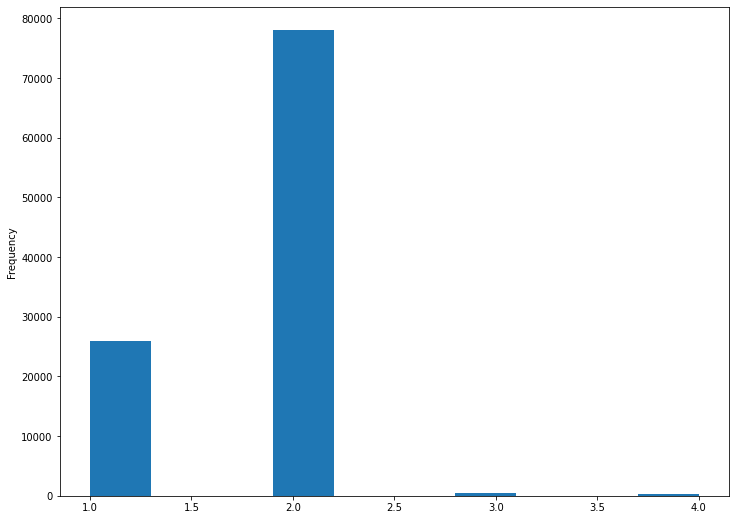

In [ ]:
train.Q13a.plot.hist(10000)

la plus part ont repondu NON à la question: Épargner l'argent dans une banque/institutions financières


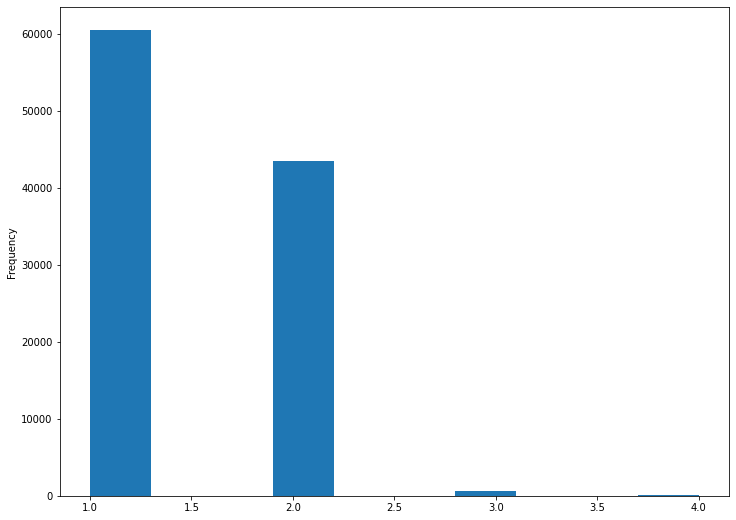

In [ ]:
train.Q21.plot.hist(10000)


Plus que 60000 ont repondu par OUI à la question: Q21, "Paiements pour l'électricité, l'eau ou les ordures au cours des 12 derniers mois",



 **la correlation entre les colonnes**

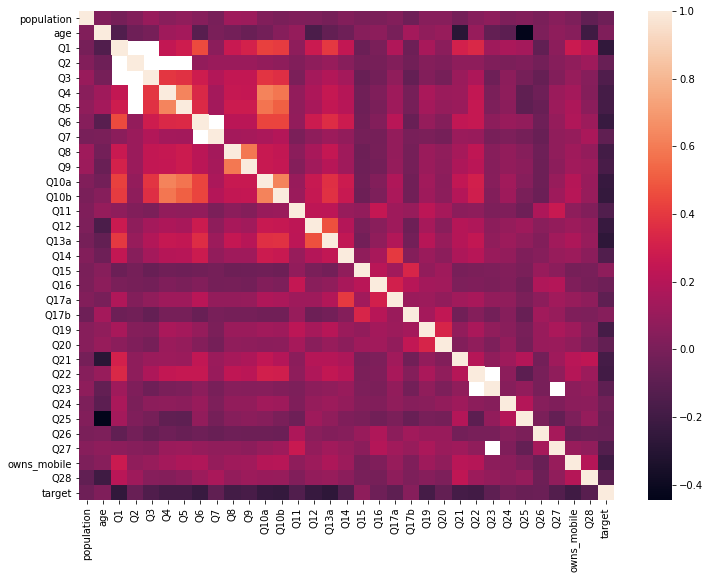

In [ ]:

sns.heatmap(train.corr())

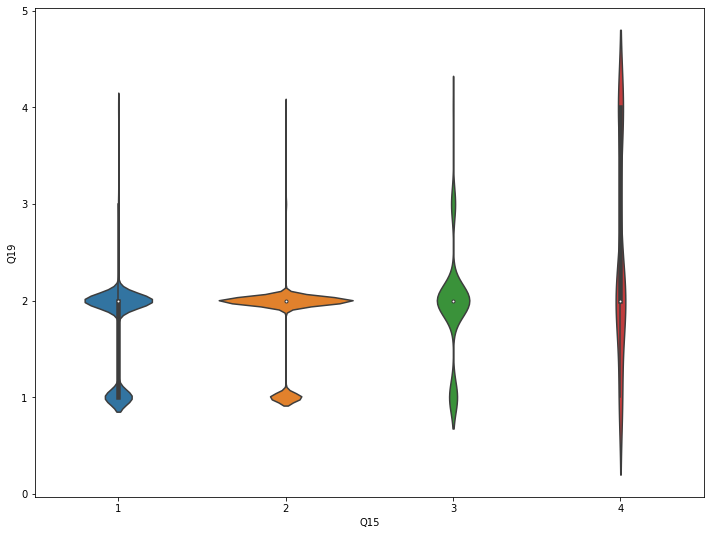

In [ ]:
sns.violinplot(x = 'Q15',y = 'Q19',data= train)


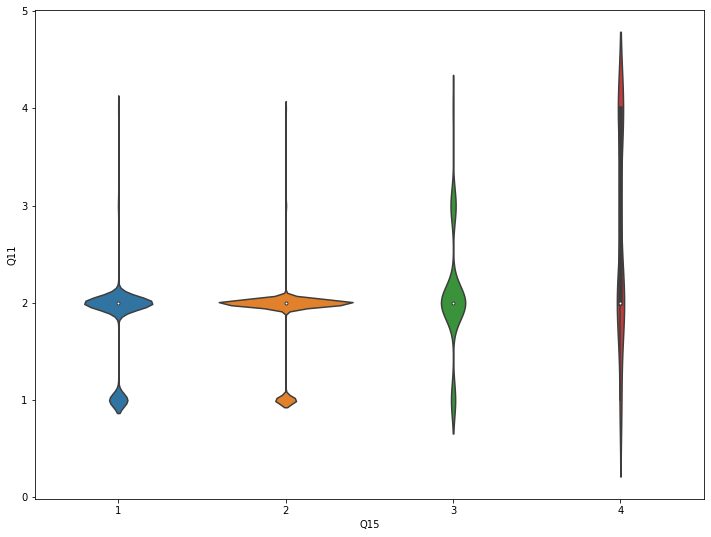

In [ ]:
sns.violinplot(x = 'Q15',y = 'Q11',data= train)


Q11 Savings in the last 12 months to start a business/farm



In [ ]:
train.groupby('Q11').target.mean()

Q11
1    0.755222
2    0.553724
3    0.385993
4    0.649123
Name: target, dtype: float64

**commentaire:**

75% des personnes qui ont repondu oui à la qst 11 ce sont des individus financièrement résilients

Q15,Borrowed money for health/medical purposes in the last 12 months,

In [ ]:
train.groupby('Q15').target.mean()


Q15
1    0.463604
2    0.596140
3    0.396146
4    0.536424
Name: target, dtype: float64

In [ ]:
train.groupby('Q8').target.mean()
# Q8,Money deposits to a bank account in the last 12 months,

Q8
1.0    0.749355
2.0    0.518637
3.0    0.556604
4.0    0.715328
Name: target, dtype: float64

**distribution de l'age selon target**

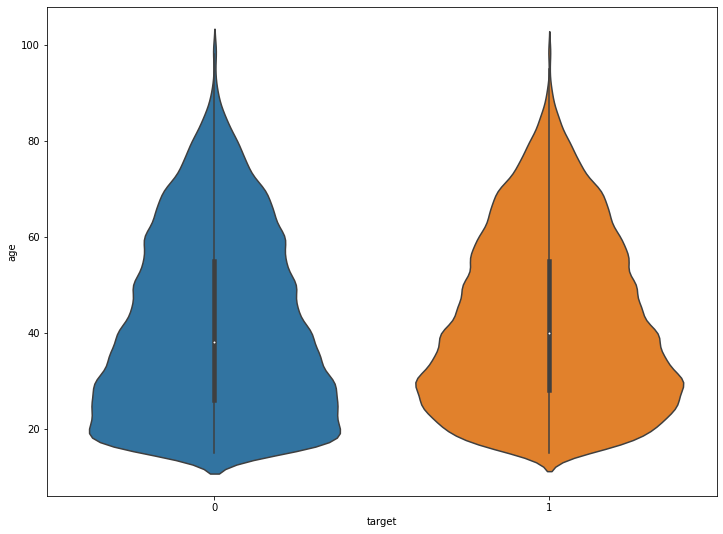

In [ ]:

sns.violinplot(x='target',y='age',data = train)

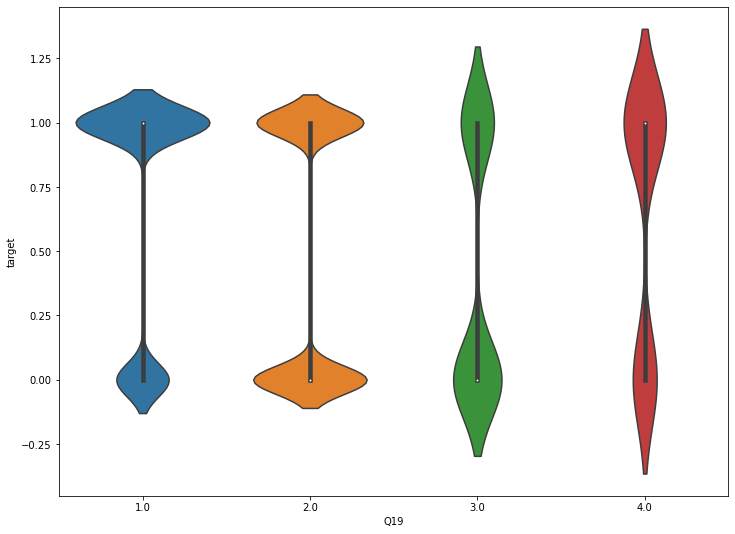

In [ ]:
#distribution du qst 19 selon target
#Q19 Sent/given money to friend/relative,
sns.violinplot(y='target',x='Q19',data = train)

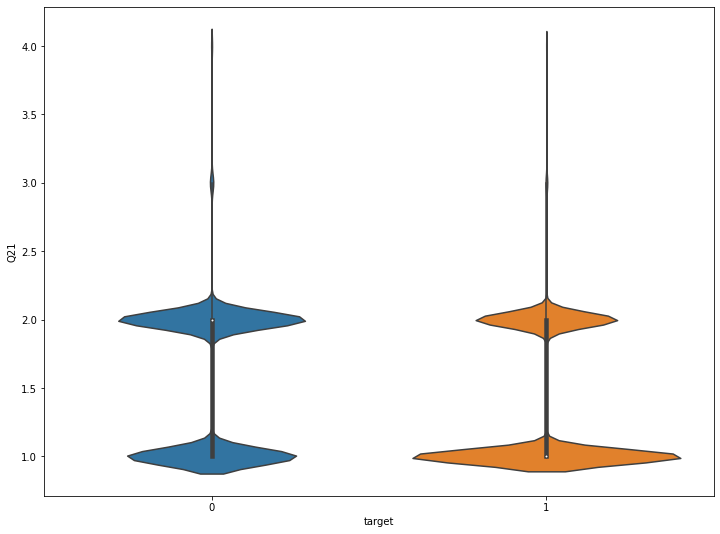

In [ ]:
#distribution du qst 21 selon target
#Q21,"Payments for electricity, water, or trash in the last 12 months",
sns.violinplot(x='target',y='Q21',data = train)

la correlation entre target les variables


In [ ]:
train.corr()[['target']].T


,population,age,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10a,Q10b,Q11,Q12,Q13a,Q14,Q15,Q16,Q17a,Q17b,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,owns_mobile,Q28,target
target,-0.036209,0.02201,-0.258509,-0.060496,-0.145656,-0.18383,-0.182326,-0.227099,-0.086263,-0.19173,-0.173636,-0.23244,-0.245217,-0.137378,-0.233556,-0.26933,-0.138913,0.069486,-0.035148,-0.091707,0.044887,-0.181315,-0.073823,-0.185826,-0.197286,-0.091015,-0.024796,-0.05387,-0.049123,-0.133749,-0.198927,-0.118289,1.0


# **Pre-Processing**

**Nettoyage de NAN**

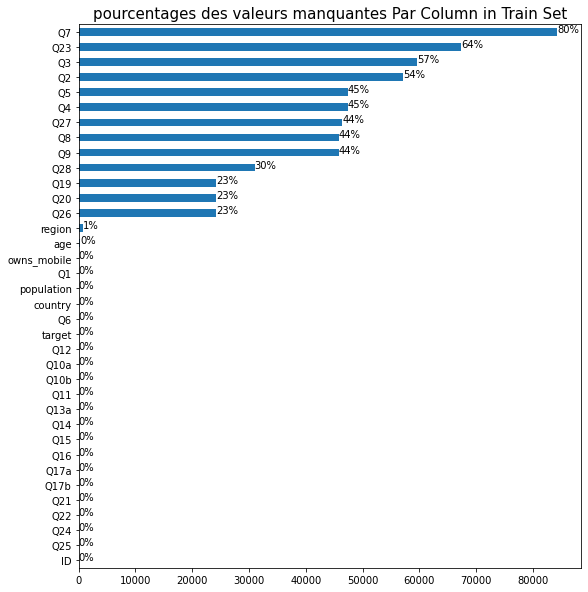

In [ ]:
# pourcentages des valeurs manquantes(NAN) dans notre dataframe :
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('pourcentages des valeurs manquantes Par Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

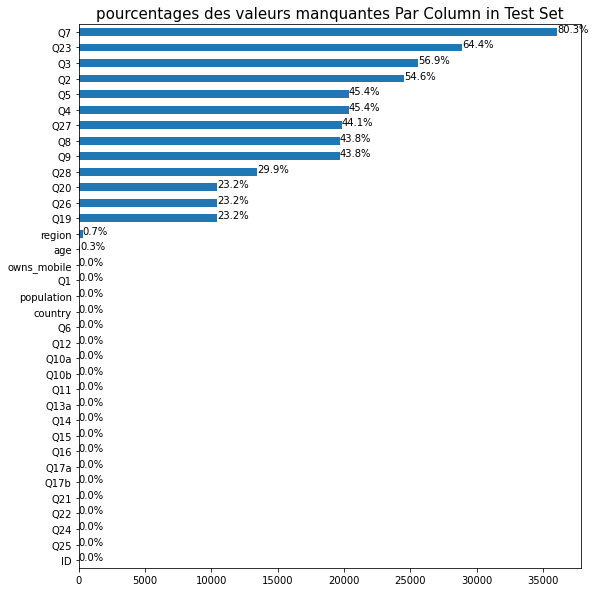

In [ ]:
# pourcentages des valeurs manquantes(NAN) dans test
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('pourcentages des valeurs manquantes Par Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [ ]:
# Combiner train et test set
ntrain = train.shape[0] # pour l'utilser en split train et test set 
all_data = pd.concat((train.drop(['Q7'],1), test.drop(['Q7'],1))).reset_index(drop=True)
print('The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: {all_data.shape}


Elimination des colonnes avec NAN >0.8 et les colonnes ID et population

In [ ]:
df = all_data[all_data.columns[all_data.isna().sum()/all_data.shape[0]<0.8]]

df = all_data.drop(['ID','population'],axis=1)

df.head()

,country,region,age,Q1,Q2,Q3,Q4,Q5,Q6,Q8,Q9,Q10a,Q10b,Q11,Q12,Q13a,Q14,Q15,Q16,Q17a,Q17b,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,owns_mobile,Q28,target
0,Morocco,Middle East & North Africa (excluding high income),66.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,2,2,2,2,2,2,1,2,2,1,2.0,1.0,1,2,NaN,1,2,2.0,2.0,1.0,1.0,0.0
1,Lebanon,Middle East & North Africa (excluding high income),44.0,2,NaN,NaN,2.0,2.0,2,1.0,1.0,2,2,2,2,1,2,2,2,1,2,2.0,2.0,1,2,NaN,2,2,2.0,1.0,1.0,1.0,1.0
2,Morocco,Middle East & North Africa (excluding high income),29.0,1,1.0,1.0,2.0,2.0,2,1.0,1.0,2,2,2,2,2,2,2,2,2,2,2.0,2.0,1,1,2.0,2,2,2.0,NaN,1.0,1.0,0.0
3,Canada,High income: OECD,44.0,1,1.0,1.0,1.0,1.0,2,1.0,1.0,1,1,2,1,1,2,2,2,1,2,NaN,NaN,1,1,2.0,1,2,NaN,NaN,1.0,NaN,1.0
4,Mexico,Latin America & Caribbean (excluding high income),36.0,2,NaN,NaN,NaN,NaN,2,NaN,NaN,1,2,2,2,2,2,2,2,2,2,2.0,2.0,1,2,NaN,1,2,2.0,2.0,1.0,1.0,1.0


remlacant les ages manquants par la moyenne, et les regions qui manquent par le mot 'inkonnu'

In [ ]:
df.loc[df['region'].isna(), 'region'] = 'inkonnu'
df.loc[df['age'].isna(), 'age'] = df['age'].mean()


on va remplacer les NAN dans les questions 1 jusqu'à 28 par 3=Don’t Know

In [ ]:
df = df.fillna(3)

In [ ]:
df.isnull().sum()

country        0
region         0
age            0
Q1             0
Q2             0
Q3             0
Q4             0
Q5             0
Q6             0
Q8             0
Q9             0
Q10a           0
Q10b           0
Q11            0
Q12            0
Q13a           0
Q14            0
Q15            0
Q16            0
Q17a           0
Q17b           0
Q19            0
Q20            0
Q21            0
Q22            0
Q23            0
Q24            0
Q25            0
Q26            0
Q27            0
owns_mobile    0
Q28            0
target         0
dtype: int64

In [ ]:
df.head()

,country,region,age,Q1,Q2,Q3,Q4,Q5,Q6,Q8,Q9,Q10a,Q10b,Q11,Q12,Q13a,Q14,Q15,Q16,Q17a,Q17b,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,owns_mobile,Q28,target
0,Morocco,Middle East & North Africa (excluding high income),66.0,2,3.0,3.0,3.0,3.0,2,3.0,3.0,2,2,2,2,2,2,1,2,2,1,2.0,1.0,1,2,3.0,1,2,2.0,2.0,1.0,1.0,0.0
1,Lebanon,Middle East & North Africa (excluding high income),44.0,2,3.0,3.0,2.0,2.0,2,1.0,1.0,2,2,2,2,1,2,2,2,1,2,2.0,2.0,1,2,3.0,2,2,2.0,1.0,1.0,1.0,1.0
2,Morocco,Middle East & North Africa (excluding high income),29.0,1,1.0,1.0,2.0,2.0,2,1.0,1.0,2,2,2,2,2,2,2,2,2,2,2.0,2.0,1,1,2.0,2,2,2.0,3.0,1.0,1.0,0.0
3,Canada,High income: OECD,44.0,1,1.0,1.0,1.0,1.0,2,1.0,1.0,1,1,2,1,1,2,2,2,1,2,3.0,3.0,1,1,2.0,1,2,3.0,3.0,1.0,3.0,1.0
4,Mexico,Latin America & Caribbean (excluding high income),36.0,2,3.0,3.0,3.0,3.0,2,3.0,3.0,1,2,2,2,2,2,2,2,2,2,2.0,2.0,1,2,3.0,1,2,2.0,2.0,1.0,1.0,1.0


In [ ]:
from sklearn.preprocessing import OneHotEncoder

CATEGORICAL_FEATURES = ['region','country']
cat_df = df[CATEGORICAL_FEATURES].copy()
cat_df

,region,country
0,Middle East & North Africa (excluding high income),Morocco
1,Middle East & North Africa (excluding high income),Lebanon
2,Middle East & North Africa (excluding high income),Morocco
3,High income: OECD,Canada
4,Latin America & Caribbean (excluding high income),Mexico
...,...,...
149805,Europe & Central Asia (excluding high income),"Macedonia, FYR"
149806,Latin America & Caribbean (excluding high income),Dominican Republic
149807,Middle East & North Africa (excluding high income),Lebanon
149808,Sub-Saharan Africa (excluding high income),Madagascar


**convertir les colonnes catégorielles en des colonnes numériques**

In [ ]:

#Encodage on utilisant onehotencoder
from sklearn.preprocessing import OneHotEncoder

CATEGORICAL_FEATURES = ['country', 'region']
cat_df = df[CATEGORICAL_FEATURES].copy()
cat_df

one_hot_encoder = OneHotEncoder(drop='first')
cat_features = one_hot_encoder.fit_transform(cat_df).todense()
df_1 = pd.DataFrame(cat_features, columns=one_hot_encoder.get_feature_names())

In [ ]:
df_2 = df.drop(['country','region'],axis=1)

In [ ]:
df = pd.concat([df_2,df_1],axis = 1)

In [ ]:
# Separer train et test data from the combined dataframe
train_df = df[:ntrain]
test_df = df[ntrain:]

#Shapes of the split dataset
train_df.shape, test_df.shape

((104867, 182), (44943, 182))

In [ ]:
train_df.sample(5)

,age,Q1,Q2,Q3,Q4,Q5,Q6,Q8,Q9,Q10a,Q10b,Q11,Q12,Q13a,Q14,Q15,Q16,Q17a,Q17b,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,owns_mobile,Q28,target,x0_Albania,x0_Algeria,x0_Argentina,x0_Armenia,x0_Australia,x0_Austria,x0_Azerbaijan,x0_Bahrain,x0_Bangladesh,...,x0_Serbia,x0_Sierra Leone,x0_Singapore,x0_Slovak Republic,x0_Slovenia,x0_South Africa,x0_South Sudan,x0_Spain,x0_Sri Lanka,x0_Sweden,x0_Switzerland,"x0_Taiwan, China",x0_Tajikistan,x0_Tanzania,x0_Thailand,x0_Togo,x0_Trinidad and Tobago,x0_Tunisia,x0_Turkey,x0_Turkmenistan,x0_Uganda,x0_Ukraine,x0_United Arab Emirates,x0_United Kingdom,x0_United States,x0_Uruguay,x0_Uzbekistan,"x0_Venezuela, RB",x0_Vietnam,x0_West Bank and Gaza,x0_Zambia,x0_Zimbabwe,x1_Europe & Central Asia (excluding high income),x1_High income: OECD,x1_High income: nonOECD,x1_Latin America & Caribbean (excluding high income),x1_Middle East & North Africa (excluding high income),x1_South Asia,x1_Sub-Saharan Africa (excluding high income),x1_inkonnu
10661,53.0,1,1.0,1.0,2.0,1.0,1,1.0,1.0,1,1,2,1,1,1,2,2,1,2,2.0,2.0,1,1,2.0,2,2,2.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
39232,32.0,2,3.0,3.0,3.0,3.0,2,3.0,3.0,2,2,2,2,2,2,2,2,2,2,2.0,2.0,1,1,2.0,2,2,2.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
51788,64.0,2,3.0,3.0,3.0,3.0,2,3.0,3.0,2,2,2,2,2,2,1,2,2,1,2.0,2.0,2,2,3.0,2,2,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
20942,47.0,1,1.0,1.0,1.0,1.0,1,1.0,1.0,1,1,1,1,1,2,2,2,2,2,3.0,3.0,1,1,2.0,2,2,3.0,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
67237,18.0,2,3.0,3.0,3.0,3.0,2,3.0,3.0,2,2,2,2,2,2,2,2,2,2,1.0,2.0,2,1,2.0,2,2,1.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
main_cols = df.columns.difference(['ID', 'target'])
X = train_df[main_cols]
y = train_df.target.astype(int)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# **Création du modele**

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier



**le modèle KNeighbors**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

model = KNeighborsClassifier()
baseline = DummyClassifier(strategy='most_frequent')

model.fit(X_train, y_train)
baseline.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.60      0.59      0.60     13157
           1       0.71      0.72      0.71     18304

    accuracy                           0.67     31461
   macro avg       0.66      0.66      0.66     31461
weighted avg       0.67      0.67      0.67     31461




**le modèle Xgboost**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42,stratify=y)
clf_xgb = xgb.XGBClassifier( learning_rate =0.1, d=150, max_depth=8,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight=1, seed=27)
clf_xgb.fit(X_train,y_train,verbose=False,early_stopping_rounds=50,eval_metric='auc',eval_set=[(X_test,y_test)])#eval_metric='aucpr',eval_set=[(X_test,y_test)]
y_pred = clf_xgb.predict_proba(X_test)[:, 1]
# le auc score du modele
print(f'XGBOOST AUC score on the X_test is: {roc_auc_score(y_test, y_pred)}\n')
# print classification report
print(classification_report(y_test, [1 if x >= 0.5 else 0 for x in y_pred]))

XGBOOST AUC score on the X_test is: 0.7973633988142662

              precision    recall  f1-score   support

           0       0.68      0.65      0.66     13157
           1       0.76      0.78      0.77     18304

    accuracy                           0.72     31461
   macro avg       0.72      0.71      0.72     31461
weighted avg       0.72      0.72      0.72     31461

